In [408]:
#import stuff
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time




In [409]:
# Define function

def f(x,y):
    z =  np.power(x, 2) + np.power(y, 2)
    return z

Text(0.5, 0, 'z')

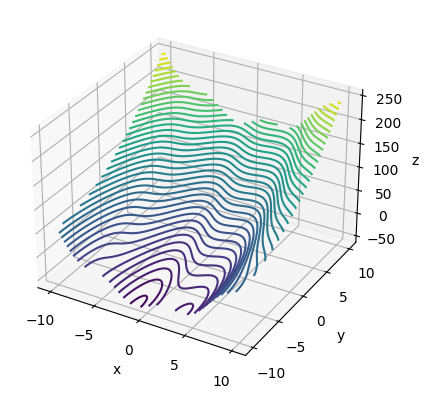

In [410]:
# Plot function

x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)


ax = plt.axes(projection = '3d')
ax.contour3D(X, Y, Z, 50)#, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


In [411]:
# Create dataset

input = np.random.random([10000, 2]) * 20 -10
output = f(input[:, 0], input[:, 1])

tensor_input = torch.Tensor(input)
tensor_output = torch.Tensor(output)





dataset = TensorDataset(tensor_input, tensor_output)
dataloader = DataLoader(dataset)

print(input.dtype)

float64


In [412]:
# Define neural network

# Define neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x))
        x = self.fc4(x) # Linear activation for final layer
        return x


net = Net()
summary(net, (1, 2))
print(net)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]              30
            Linear-2                [-1, 1, 10]             110
            Linear-3                [-1, 1, 10]             110
            Linear-4                 [-1, 1, 1]              11
Total params: 261
Trainable params: 261
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
Net(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)


In [413]:

test_in = torch.Tensor([7, 8])
test_out = net(test_in)
print(test_in.size())
print(test_out.size())
print(test_out)
print(test_out.dtype)

torch.Size([2])
torch.Size([1])
tensor([-0.3047], grad_fn=<AddBackward0>)
torch.float32


In [414]:
# Loss function and optimizer

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.000001, momentum = 0.9) 


losses = []

c:\Users\eponarv\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1,  2500] loss: 1911.887
[1,  5000] loss: 355.614
[1,  7500] loss: 256.085
[1, 10000] loss: 121.519
[2,  2500] loss: 105.482
[2,  5000] loss: 98.617
[2,  7500] loss: 95.856
[2, 10000] loss: 82.050
[3,  2500] loss: 80.241
[3,  5000] loss: 74.384
[3,  7500] loss: 77.305
[3, 10000] loss: 67.112
Finished training after:  13.5 seconds
traintime  11.4, ratio:  0.85


Text(0.5, 0, 'Iteration')

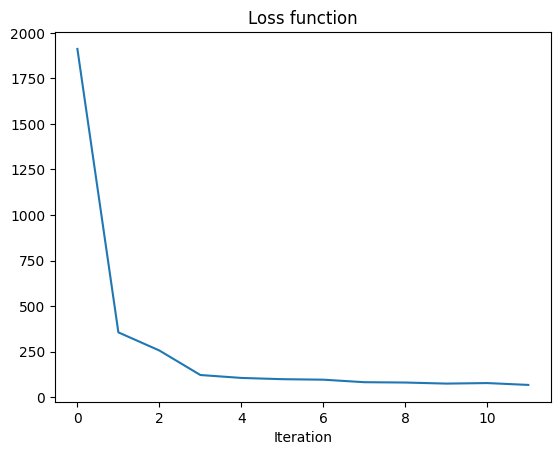

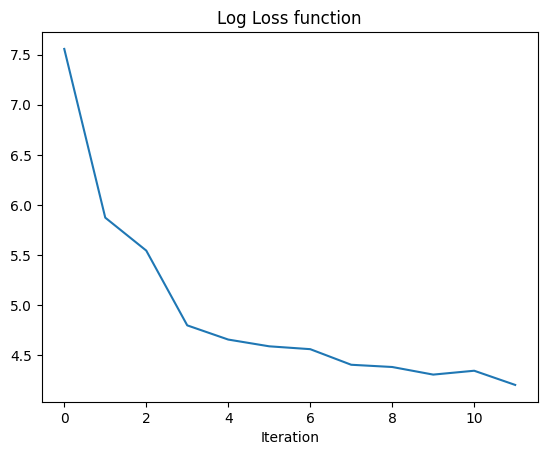

In [415]:
# Train network
traintime = 0.0
tic = time.time()
for epoch in range(3):
    running_loss = 0.0
    length = dataloader.__len__()
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        # set parameter gradients to zero
        optimizer.zero_grad()

        # forwardprop, backprop, and update parameters
        traintic = time.time()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        traintoc = time.time()
        traintime += traintoc-traintic

        # Print statistics
        running_loss += loss.item()
        if i % (length/4) == (length/4)-1:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (length/4):.3f}')
            losses.append(running_loss / (length/4))
            running_loss = 0.0
toc = time.time()
print(f'Finished training after: {toc - tic : .1f} seconds')
print(f'traintime {traintime : .1f}, ratio: {traintime / (toc-tic) : .2f}')

plt.plot(losses)
plt.title('Loss function')
plt.xlabel('Iteration')
plt.figure()

plt.plot(np.log(losses))
plt.title('Log Loss function')
plt.xlabel('Iteration')

In [416]:
print(labels.dtype)
print(outputs.dtype)

torch.float32
torch.float32


Text(0.5, 0, 'z')

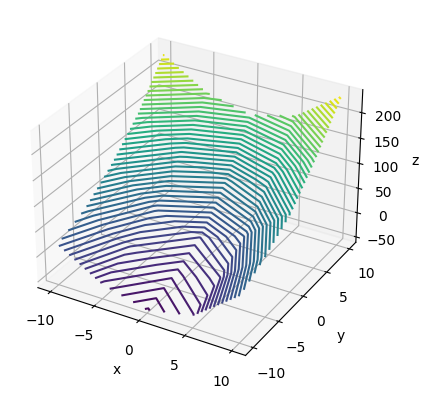

In [417]:
x = np.linspace(-10, 10, 5)
y = np.linspace(-10, 10, 5)
X, Y = np.meshgrid(x, y)

X_flat = np.matrix(X.ravel()).transpose()
Y_flat = np.matrix(Y.ravel()).transpose()


XY = np.append(X_flat, Y_flat, axis=1)

output = net(torch.Tensor(XY))

Z_est = output.detach().numpy().transpose()
Z_est = np.reshape(Z_est, X.shape)




ax = plt.axes(projection = '3d')
ax.contour3D(X, Y, Z_est, 50)#, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
